# Sparse Neural Additive Models (SNAM)
Xu et al, 2022

In [3]:
import time
import datetime
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
#from torch.optim.lr_scheduler import ExponentialLR
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.datasets import fetch_california_housing
#from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import wandb

from src.utils import data_loader, time_series_splitter
from src.snam.utils import groupl1, data_totensor, load_model, save_train_artifacts, load_train_artifacts
from src.snam.snam import NAM, SampleNet, PyramidNet
from src.snam.train import fit_model, compile_model
from src.snam.plot import plot_shape_functions
from src.snam.eval import count_selected_features, predict_and_evaluate_model

# Set up

In [4]:
# activate venv & log into wandb
#!source ../ml-env/bin/activate
wandb.login()

## Path to data
root_path = "./data/"
print(root_path)

## setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m-janyellow. Use `wandb login --relogin` to force relogin


./data/
cuda:0


# Data Loading and Preprocessing

In [5]:
# Load subsample
#subsample_path = '/subsample_processed_scaled.csv'
subsample_path = '/subsample_processed_scaled_1000.csv'
fullsample_path = '/data_processed_scaled.csv'

# Model & Train

### Experiment: all features, SampleNet as subnetworks, few epochs
-> use utils!

In [5]:
##### Train pipeline

# load and prepare data
data = data_loader(root_path, subsample_path, pickle=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(data)
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid)

# def hyperparams
lbd, lr, max_epoch, MSE, n_features, opti_name, pyramid, adaptive_lr = 1, 1e-3, int(10), True, X_train.shape[1], 'Adam', False, True
run_id = '100'
save_dir = './models/snam/'

# compile model
model, optimizer = compile_model(lbd, lr, n_features, output_size, opti_name, device, pyramid)

# fit model
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = fit_model(trainloader, testloader, n_features, model, optimizer, device, max_epoch, 
                                                                                          run_id, torch_seed=0, test=True, MSE=MSE, save_dir=save_dir, 
                                                                                          adaptive_lr=adaptive_lr)

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], y_train, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('test loss: ', test_loss)

<class 'pandas.core.frame.DataFrame'>


current_lr,▁
learning_rate,▁
max_epochs,▁
n_features,▁
current_lr,0.001
learning_rate,0.001
max_epochs,10
n_features,67
optimizer,Adam


Training on: cuda:0
################################## START OF TRAINING ##################################
##### Training Epoch Nr: 0 started ####


252it [00:33,  7.56it/s]
252it [00:32,  7.85it/s]
252it [00:32,  7.85it/s]
252it [00:32,  7.86it/s]
252it [00:31,  7.90it/s]


##### Training Epoch Nr: 5 started ####


252it [00:32,  7.83it/s]
252it [00:32,  7.81it/s]
252it [00:32,  7.84it/s]
252it [00:31,  7.90it/s]
252it [00:32,  7.85it/s]


test loss : 0.014780213832165356
epoch:  10 Loss train:  0.012602065507847343 Loss test:  0.014780213832165356
333.5699324607849
f_tr_out:  [[-1.75431126e-07]
 [-3.16343375e-07]
 [-6.08305584e-07]
 [ 9.30362773e-07]
 [ 4.71916941e-08]
 [-1.48696969e-07]
 [ 7.05992534e-07]
 [-4.92674815e-07]
 [-6.49370691e-07]
 [-5.05755565e-07]
 [-4.33694879e-07]
 [ 1.20315434e-07]
 [-9.08763411e-08]
 [-1.79228834e-06]
 [-4.15836951e-07]
 [ 1.15445994e-06]
 [ 1.49373795e-06]
 [-9.01809130e-07]
 [-8.39666086e-07]
 [-5.59194746e-07]
 [ 3.10103314e-06]
 [ 1.30985359e-06]
 [ 1.99040483e-06]
 [-8.33934848e-07]
 [ 2.72490013e-07]
 [-1.82626889e-06]
 [ 1.15252010e-06]
 [ 2.13017103e-07]
 [-4.07582945e-07]
 [ 1.69091493e-07]
 [-2.79095332e-07]
 [-4.10354858e-07]
 [-1.00979707e-06]
 [ 2.12846899e-07]
 [ 1.17939089e-06]
 [-2.08048760e-07]
 [-1.18367552e-06]
 [-2.07465678e-06]
 [-2.36235337e-06]
 [ 1.00847149e-06]
 [ 3.76491869e-07]
 [-3.78865508e-07]
 [-2.98584337e-06]
 [ 1.03577101e-07]
 [-2.03666659e-07]
 [ 5.

/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/snam/train.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)),


NameError: name 'time_spent' is not defined

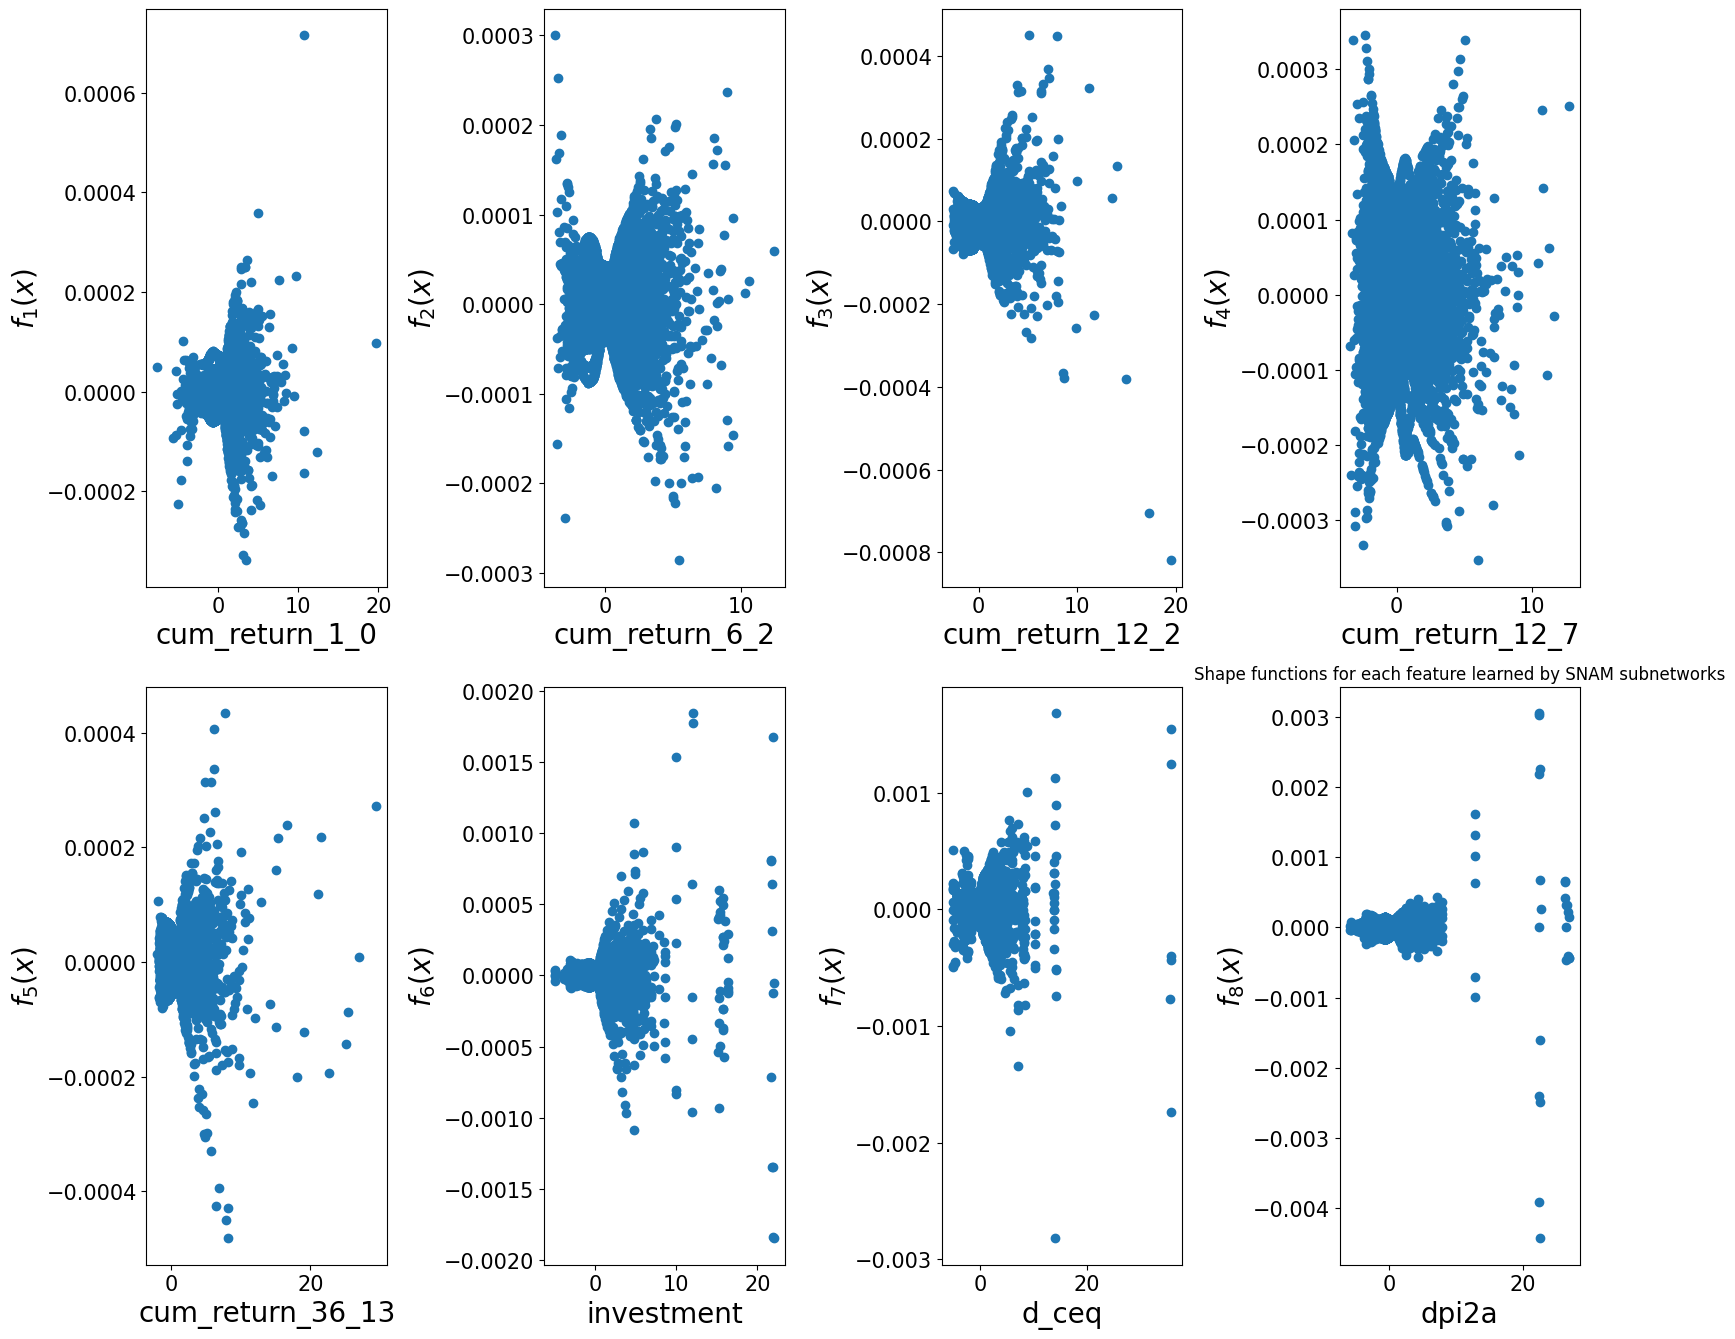

In [21]:
plot_shape_functions(X_train, n_features, f_out_tr, nrows=2, ncols=4, save=True, run_id=run_id)

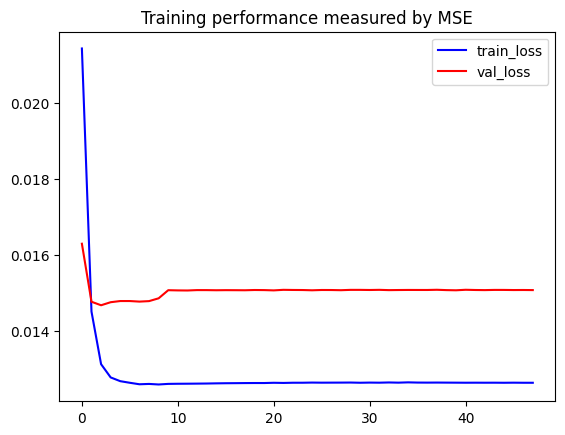

In [48]:
#plt.style.use("seaborn")
plt.title('Training performance measured by MSE')
plt.plot(train_loss_history[2:], c='b', label='train_loss')
plt.plot(test_loss_history[2:], c='r', label='val_loss')
plt.legend()
#plt.savefig('./models/snam/train_history_113.png')

### Experiment: pyramid architecture, more epochs

In [29]:
##### Train pipeline

# load and prepare data
data = data_loader(root_path, subsample_path, pickle=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(data)
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid)

# def hyperparams
lbd, lr, max_epoch, MSE, n_features, opti_name, pyramid, adaptive_lr = 1, 1e-3, int(50), True, X_train.shape[1], 'Adam', True, True
run_id = '114'
save_dir = './models/snam/'

# compile model
model, optimizer = compile_model(lbd, lr, n_features, output_size, opti_name, device, pyramid)

# fit model
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = fit_model(trainloader, testloader, n_features, model, optimizer, device, max_epoch, 
                                                                                          run_id, torch_seed=0, test=True, MSE=MSE, save_dir=save_dir, 
                                                                                          adaptive_lr=adaptive_lr)

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], y_train, plot=True)
#print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('test loss: ', test_loss)

<class 'pandas.core.frame.DataFrame'>


Training on: cuda:0
################################## START OF TRAINING ##################################
##### Training Epoch Nr: 0 started ####


252it [00:31,  7.98it/s]
252it [00:31,  7.88it/s]
252it [00:31,  7.88it/s]
252it [00:31,  7.89it/s]
252it [00:31,  7.88it/s]


##### Training Epoch Nr: 5 started ####


252it [00:34,  7.23it/s]
252it [00:32,  7.87it/s]
252it [00:32,  7.87it/s]
252it [00:32,  7.87it/s]
252it [00:31,  7.90it/s]


test loss : 0.014780213832165356
epoch:  10 Loss train:  0.012602065507847343 Loss test:  0.014780213832165356
##### Training Epoch Nr: 10 started ####


252it [00:31,  7.89it/s]
252it [00:31,  7.89it/s]
252it [00:31,  7.91it/s]
252it [00:31,  7.91it/s]
252it [00:31,  7.88it/s]


##### Training Epoch Nr: 15 started ####


252it [00:32,  7.87it/s]
252it [00:31,  7.91it/s]
252it [00:31,  7.90it/s]
252it [00:32,  7.87it/s]
252it [00:31,  7.88it/s]


test loss : 0.015065708801288295
epoch:  20 Loss train:  0.012624577015808354 Loss test:  0.015065708801288295
##### Training Epoch Nr: 20 started ####


252it [00:32,  7.87it/s]
252it [00:31,  7.91it/s]
252it [00:31,  7.90it/s]
252it [00:31,  7.91it/s]
252it [00:32,  7.87it/s]


##### Training Epoch Nr: 25 started ####


252it [00:31,  7.89it/s]
252it [00:31,  7.88it/s]
252it [00:31,  7.90it/s]
252it [00:31,  7.88it/s]
252it [00:31,  7.89it/s]


test loss : 0.015067167062726285
epoch:  30 Loss train:  0.012636829461414544 Loss test:  0.015067167062726285
##### Training Epoch Nr: 30 started ####


252it [00:31,  7.88it/s]
252it [00:31,  7.93it/s]
252it [00:31,  7.93it/s]
252it [00:31,  7.90it/s]
252it [00:31,  7.90it/s]


##### Training Epoch Nr: 35 started ####


252it [00:32,  7.86it/s]
252it [00:31,  7.94it/s]
252it [00:31,  7.90it/s]
252it [00:31,  7.94it/s]
252it [00:31,  7.89it/s]


test loss : 0.015078384618930242
epoch:  40 Loss train:  0.012637901325000539 Loss test:  0.015078384618930242
##### Training Epoch Nr: 40 started ####


252it [00:32,  7.85it/s]
252it [00:32,  7.81it/s]
252it [00:32,  7.87it/s]
252it [00:31,  7.88it/s]
252it [00:31,  7.89it/s]


##### Training Epoch Nr: 45 started ####


252it [00:32,  7.85it/s]
252it [00:31,  7.91it/s]
252it [00:32,  7.86it/s]
252it [00:31,  7.92it/s]
252it [00:31,  7.88it/s]


test loss : 0.015070159333171669
epoch:  50 Loss train:  0.012632534323659326 Loss test:  0.015070159333171669
1658.1011633872986
f_tr_out:  [[-1.03449366e-07]
 [-5.45573357e-07]
 [ 8.38793881e-07]
 [ 6.03843660e-07]
 [-6.18246702e-07]
 [ 1.60814082e-08]
 [-5.07172388e-07]
 [ 2.05036145e-07]
 [ 6.55153940e-07]
 [ 4.92659069e-08]
 [-2.57217010e-07]
 [-8.07693596e-07]
 [ 3.25718503e-07]
 [-7.01425904e-07]
 [ 6.97775931e-07]
 [ 1.25022314e-06]
 [-2.55811248e-08]
 [ 1.53924148e-07]
 [-3.29707461e-07]
 [-2.20672305e-07]
 [ 8.24615256e-07]
 [ 2.93926917e-07]
 [-3.25830151e-05]
 [ 6.12407973e-07]
 [-1.22531469e-06]
 [ 2.91538981e-07]
 [-6.83185348e-08]
 [-8.62898901e-07]
 [ 6.76029345e-07]
 [ 1.86323007e-06]
 [ 8.49697244e-07]
 [ 5.31663375e-07]
 [-4.29875342e-07]
 [-1.44994874e-06]
 [-3.49314995e-08]
 [-1.04886581e-07]
 [ 1.34481729e-06]
 [ 9.76125079e-07]
 [ 4.74663835e-07]
 [ 3.21469571e-07]
 [ 2.46552787e-08]
 [-1.64510908e-07]
 [ 2.71281374e-06]
 [ 1.01742842e-06]
 [ 2.24520662e-07]
 [ 7

/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/snam/train.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)),


#### Look at the training results

NameError: name 'path' is not defined

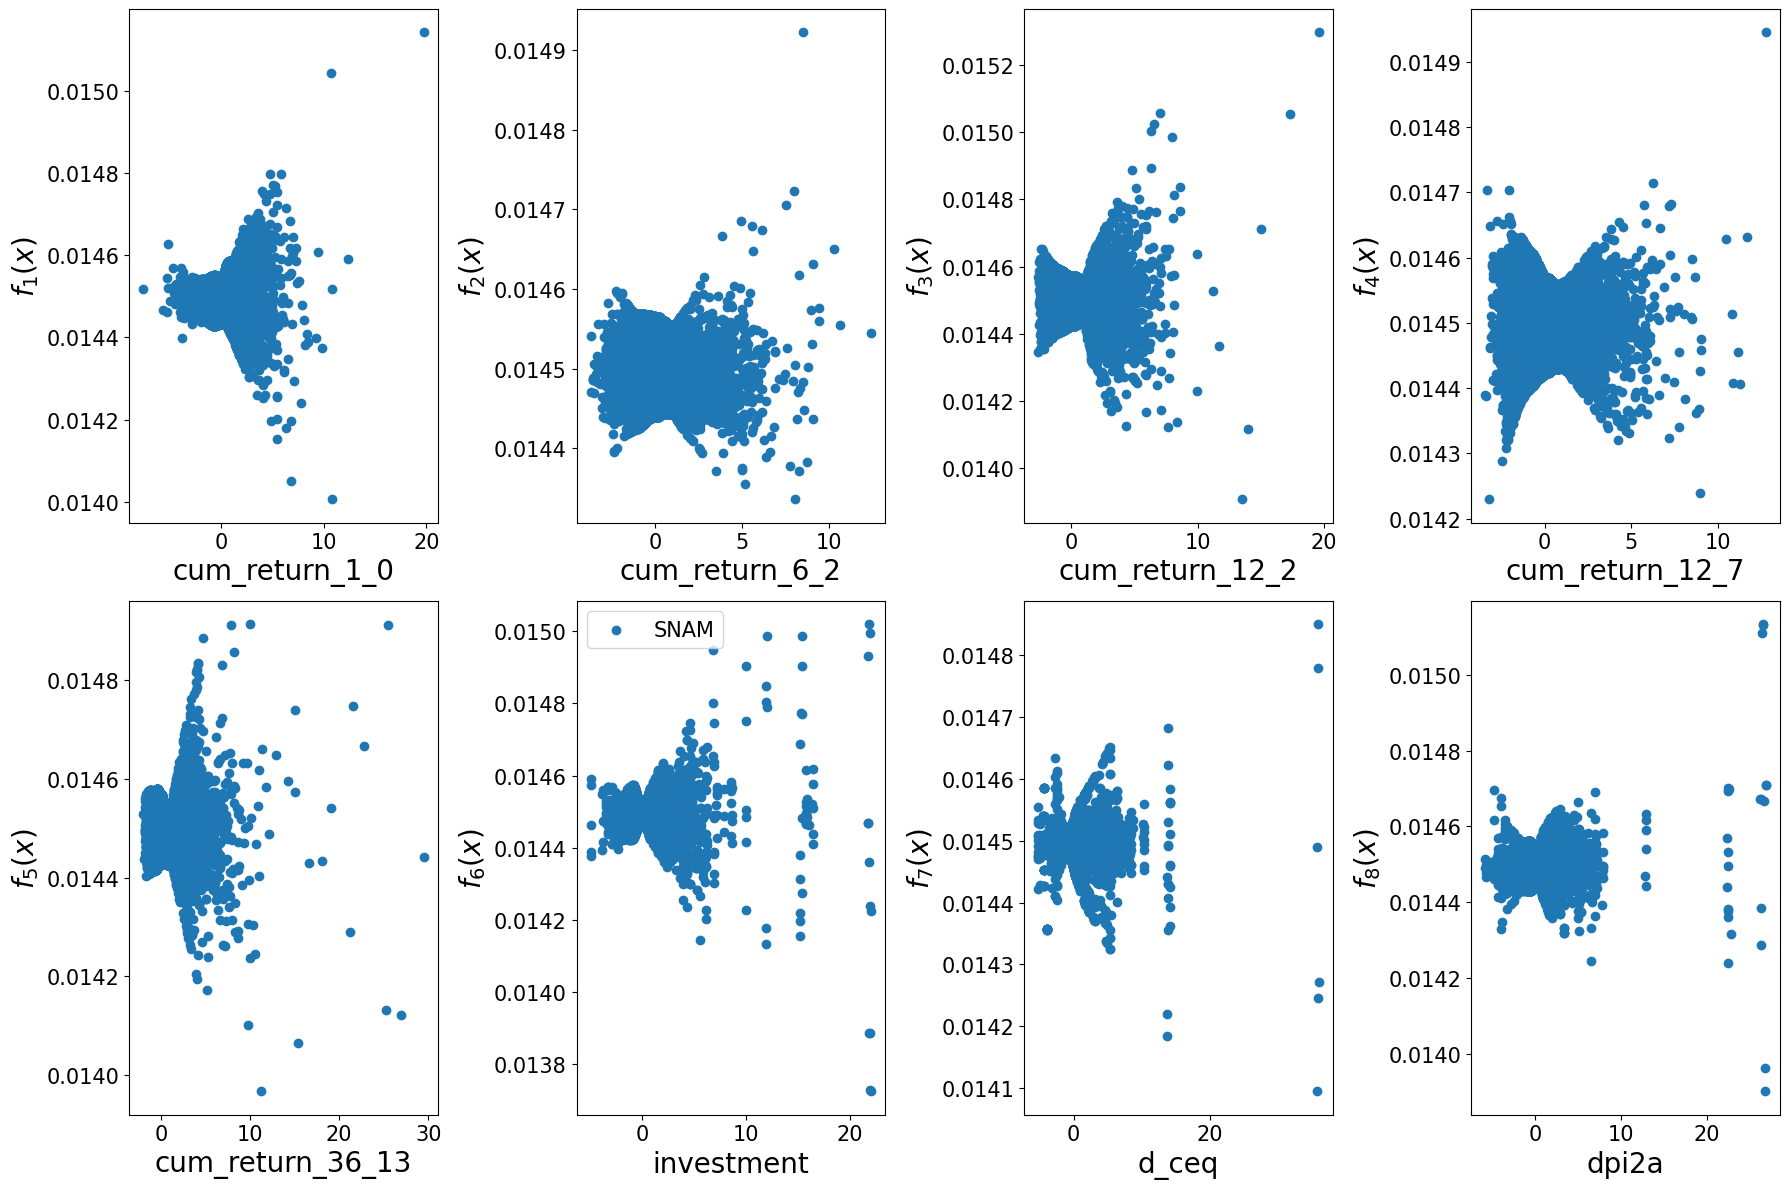

In [37]:
# lets see what the network learned
plot_shape_functions(f_out_tr, save=True, run_id=run_id)

In [45]:
## Save some artifacts for later, now use:
# save_train_artifacts(f_out_tr, f_out_te, train_loss_history, test_loss_history,
#                        train_shape=X_train.shape, val_shape=X_valid.shape, 
#                        test_shape=X_test.shape, save_dir='./models/snam/')

# and for loading them again:
# run_id=115
# load_train_artifacts(run_id, save_dir='./models/snam/')

############################################################
model_artifacts = {}
model_artifacts['f_out_tr'], model_artifacts['f_out_te'] = f_out_tr, f_out_te

model_artifacts['train_loss'], model_artifacts['val_loss'] = train_loss_history, test_loss_history

model_artifacts['n_train_samples'], model_artifacts['n_val_samples'], model_artifacts['n_test_samples'] = \
X_train.shape, X_valid.shape, X_test.shape

##%%save
with open("./models/snam/artifacts_115.pkl","wb") as f:
    pickle.dump(model_artifacts, f)

#### Inspect the learned f_j(x)

In [18]:
## how many samples??
data = data_loader(root_path, subsample_path, pickle=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(data)
print(f'There were {X_train.shape[0]} train samples \n {X_valid.shape[0]} valid samples \n and {X_test.shape[0]} test samples')

<class 'pandas.core.frame.DataFrame'>
There were 64502 train samples 
 26273 valid samples 
 and 130793 test samples


In [14]:
# load the f_j's
with open("models/snam/f_j_x_114.pkl", "rb") as f:
    f_j_x = pickle.load(f)

f_j_tr, f_j_te = f_j_x['f_out_tr'], f_j_x['f_out_te']

In [19]:
print(f"f_j(x)_tr is of type {type(f_j_tr)} \n and has shape {f_j_tr.shape}")
print("\n")
print(f"f_j(x)_te is of type {type(f_j_te)} \n and has shape {f_j_te.shape}")

f_j(x)_tr is of type <class 'numpy.ndarray'> 
 and has shape (64502, 67, 1)


f_j(x)_te is of type <class 'numpy.ndarray'> 
 and has shape (18291, 1)


In [24]:
# f_j_tr is a tensor with depth-1 practically a matrix. Now, bring it into a 2d-array:
f_j_tr = np.squeeze(f_j_tr)
f_j_tr.shape

(64502, 67)

In [26]:
# make it a pd dataframe for further processing
f_j_df = pd.DataFrame(f_j_tr)
f_j_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
count,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,...,64502.000000,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04,6.450200e+04
mean,-1.034484e-07,-5.455764e-07,8.387927e-07,6.038446e-07,-6.182455e-07,1.608158e-08,-5.071724e-07,2.050369e-07,6.551917e-07,4.926667e-08,...,0.000002,-5.688552e-07,2.700801e-07,-5.743640e-07,-3.451779e-07,1.098976e-06,1.010131e-06,1.335606e-07,-2.308144e-06,1.247744e-06
std,2.568594e-05,2.016240e-05,3.103129e-05,3.077728e-05,3.216130e-05,1.763976e-05,1.451903e-05,1.845246e-05,8.571990e-05,2.915367e-05,...,0.000043,1.567362e-05,2.285485e-05,1.808418e-05,2.765902e-05,2.261066e-05,3.944940e-05,8.041481e-05,5.047043e-05,4.172567e-05
min,-4.883416e-04,-1.591370e-04,-5.862789e-04,-2.641524e-04,-5.280467e-04,-7.688744e-04,-3.998654e-04,-5.925062e-04,-1.175029e-03,-4.826661e-04,...,-0.000667,-6.298495e-04,-6.142159e-04,-3.938367e-04,-3.092227e-04,-2.612525e-04,-1.053427e-04,-5.368165e-04,-1.902853e-04,-1.505289e-04
25%,-1.004961e-05,-1.191064e-05,-9.886912e-06,-1.789552e-05,-1.873887e-05,-4.378681e-06,-7.091023e-06,-6.201380e-06,-4.877608e-05,-1.473532e-05,...,-0.000019,-6.542702e-06,-1.084833e-05,-7.693401e-06,-7.881401e-06,-6.822170e-06,-2.545601e-05,-2.216551e-05,-2.557625e-05,-2.260250e-05
50%,1.336800e-07,-1.148837e-07,2.108475e-07,-1.765586e-07,-1.942361e-06,4.004745e-08,-1.189567e-07,-6.268453e-08,3.597601e-06,4.041124e-08,...,0.000001,2.264350e-07,7.619566e-07,-3.580067e-07,3.357145e-07,9.660340e-08,-5.782665e-07,-8.143689e-07,-6.785566e-07,9.096004e-07
75%,9.765105e-06,1.059612e-05,1.024980e-05,1.830821e-05,1.766271e-05,4.817108e-06,6.646886e-06,6.519039e-06,4.208235e-05,1.501441e-05,...,0.000021,5.921249e-06,1.177157e-05,6.913300e-06,8.943450e-06,7.547870e-06,2.789844e-05,1.852230e-05,2.347795e-05,2.340853e-05
max,6.471588e-04,4.271445e-04,8.031880e-04,4.510969e-04,4.185909e-04,5.248338e-04,3.544926e-04,6.382555e-04,1.834372e-03,6.116910e-04,...,0.000970,2.464555e-04,6.886124e-04,7.852213e-04,4.846073e-04,6.783766e-04,1.488365e-04,3.124803e-04,1.427056e-04,1.948165e-04


In [35]:
# find the non-selected features -> with values=0
sum_f_j_list = []
for col in f_j_df.columns:
    sum_f_j = f_j_df[col].sum()
    #print(f"Sum of f_j_{col} = {sum_f_j}")
    sum_f_j_list.append(sum_f_j)
    
for i in range(f_j_tr.shape[-1]):
    
    print c[...,i]

In [38]:
sum(sum_f_j_list)

-1.419271002523601

-> It looks like no features were selected since all sums of f_j(x) are non-zero :(

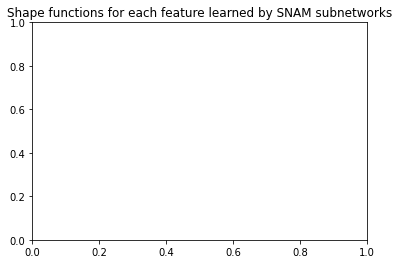

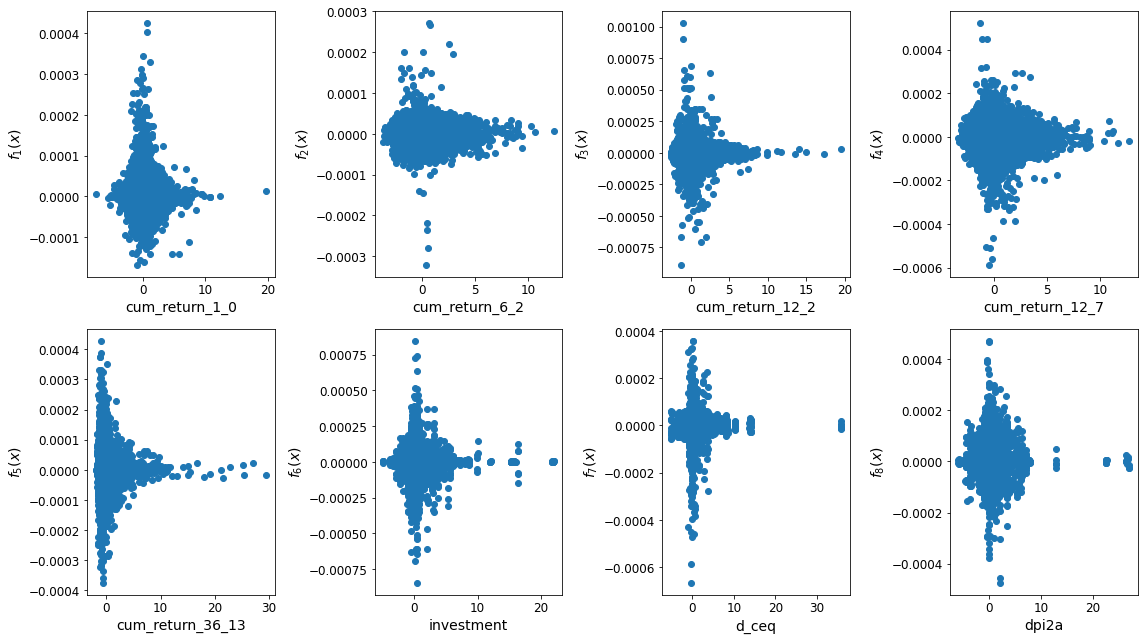

In [40]:
# plot a few f_js
f_plot = f_j_df.iloc[:,30:38].to_numpy()
plot_shape_functions(X_train, n_features=66, f_out_tr=f_plot, save=False)

## Experiment: Higher penalty, use loaded weights

In [41]:
##### Load weights, note this model is using the pyramid architecture
model_pre = load_model('model_114.pth')

In [43]:
model_pre.state_dict()

OrderedDict([('bias', tensor([0.0167], device='cuda:0')),
             ('feature_nns.0.fc1.weight',
              tensor([[ 0.5177],
                      [-0.4227],
                      [-0.1932],
                      [ 0.4635],
                      [-0.9657],
                      [ 0.5984],
                      [-0.2107],
                      [ 0.4763],
                      [ 0.1490],
                      [-0.1141],
                      [ 0.2808],
                      [ 0.0509],
                      [ 0.3664],
                      [-0.3757],
                      [-0.0535],
                      [-0.0824],
                      [ 0.1461],
                      [ 0.0180],
                      [ 0.8648],
                      [ 0.3146],
                      [-0.3530],
                      [-0.5957],
                      [-0.1745],
                      [-0.4608],
                      [-0.3117],
                      [ 0.0306],
                      [ 0.5935],
         

In [44]:
##### Train pipeline

# load and prepare data
data = data_loader(root_path, subsample_path, pickle=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = time_series_splitter(data)
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid)

# def hyperparams
lbd, lr, max_epoch, MSE, n_features, opti_name, pyramid, adaptive_lr = 3, 1e-3, int(50), True, X_train.shape[1], 'Adam', True, True
run_id = '115'
save_dir = './models/snam/'

# compile model
model, optimizer = compile_model(lbd, lr, n_features, output_size, opti_name, device, pyramid)

# fit model
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = fit_model(trainloader, testloader, n_features, model, optimizer, device, max_epoch, 
                                                                                          run_id, torch_seed=0, test=True, MSE=MSE, save_dir=save_dir, 
                                                                                          adaptive_lr=adaptive_lr)

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], y_train, plot=True)
#print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('test loss: ', test_loss)

<class 'pandas.core.frame.DataFrame'>


Training on: cuda:0
################################## START OF TRAINING ##################################
##### Training Epoch Nr: 1 started ####


252it [00:31,  7.95it/s]
252it [00:31,  8.09it/s]
252it [00:31,  7.97it/s]
252it [00:31,  8.02it/s]
252it [00:31,  8.04it/s]


##### Training Epoch Nr: 6 started ####


252it [00:31,  7.92it/s]
252it [00:31,  7.96it/s]
252it [00:32,  7.87it/s]
252it [00:31,  7.96it/s]
252it [00:31,  7.95it/s]


test loss : 0.014780213832165356
epoch:  10 Loss train:  0.012602065507847343 Loss test:  0.014780213832165356
##### Training Epoch Nr: 11 started ####


252it [00:31,  7.96it/s]
252it [00:31,  7.97it/s]
252it [00:31,  7.89it/s]
252it [00:31,  7.99it/s]
252it [00:31,  7.96it/s]


##### Training Epoch Nr: 16 started ####


252it [00:31,  7.91it/s]
252it [00:31,  7.96it/s]
252it [00:31,  7.96it/s]
252it [00:31,  7.94it/s]
252it [00:31,  7.96it/s]


test loss : 0.015065708801288295
epoch:  20 Loss train:  0.012624577015808354 Loss test:  0.015065708801288295
##### Training Epoch Nr: 21 started ####


252it [00:31,  7.91it/s]
252it [00:31,  7.96it/s]
252it [00:31,  7.97it/s]
252it [00:31,  7.98it/s]
252it [00:31,  7.98it/s]


##### Training Epoch Nr: 26 started ####


252it [00:31,  7.89it/s]
252it [00:31,  7.99it/s]
252it [00:31,  7.98it/s]
252it [00:31,  8.01it/s]
252it [00:31,  8.10it/s]


test loss : 0.015067167062726285
epoch:  30 Loss train:  0.012636829461414544 Loss test:  0.015067167062726285
##### Training Epoch Nr: 31 started ####


252it [00:31,  8.06it/s]
252it [00:31,  8.08it/s]
252it [00:31,  8.05it/s]
252it [00:31,  8.03it/s]
252it [00:31,  8.05it/s]


##### Training Epoch Nr: 36 started ####


252it [00:31,  7.98it/s]
252it [00:31,  7.91it/s]
252it [00:31,  7.98it/s]
252it [00:31,  7.97it/s]
252it [00:31,  7.99it/s]


test loss : 0.015078384618930242
epoch:  40 Loss train:  0.012637901325000539 Loss test:  0.015078384618930242
##### Training Epoch Nr: 41 started ####


252it [00:31,  7.95it/s]
252it [00:31,  7.93it/s]
252it [00:31,  8.00it/s]
252it [00:31,  8.01it/s]
252it [00:31,  7.99it/s]


##### Training Epoch Nr: 46 started ####


252it [00:31,  7.99it/s]
252it [00:31,  7.92it/s]
252it [00:31,  7.97it/s]
252it [00:31,  7.95it/s]
252it [00:31,  7.91it/s]


test loss : 0.015070159333171669
epoch:  50 Loss train:  0.012632534323659326 Loss test:  0.015070159333171669
#################### Finished training in 27.27 minutes ####################


Loss test:,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
current_lr,████████▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁
learning_rate,▁
max_epochs,▁
n_features,▁
Loss test:,0.01507
Train Loss,0.01263
current_lr,0.00059
learning_rate,0.001
max_epochs,50


test loss:  0.015070159333171669


/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/snam/train.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)),


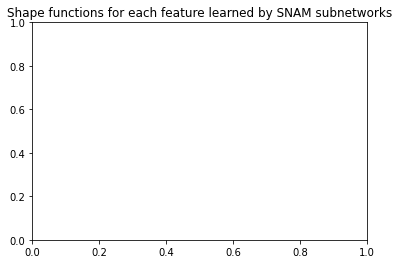

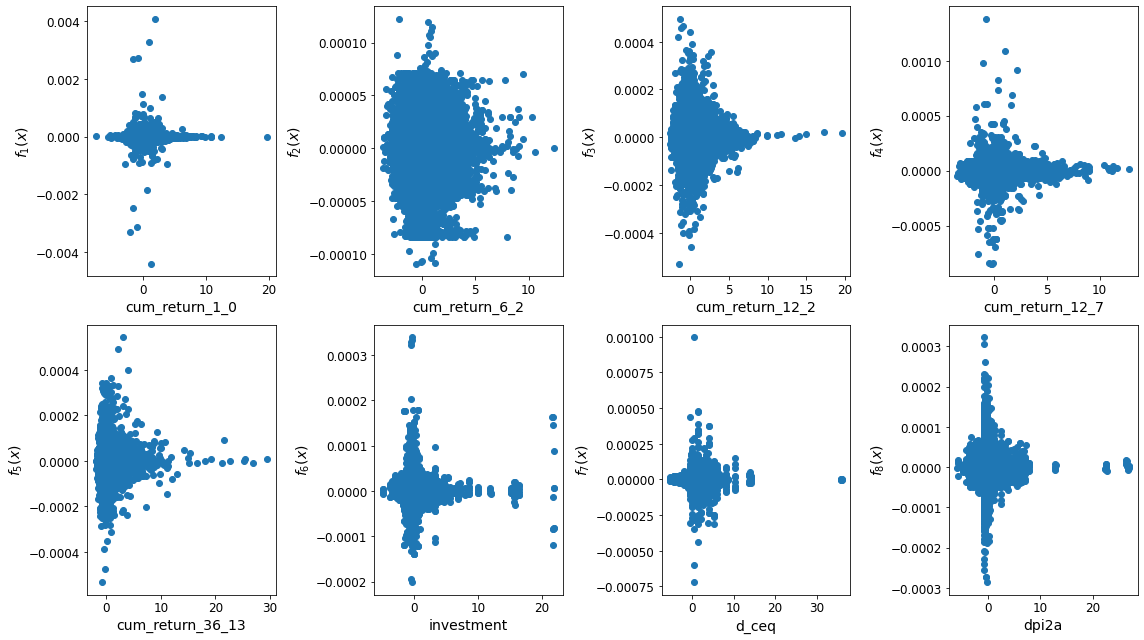

In [60]:
# plot a few f_js (from cols k to l)
k, l = 40, 48

# reshape and select data and respective col-names to plot
f_j_tr = np.squeeze(f_j_tr)
f_plot = f_j_tr[:,k:l]
cols = X_train.columns[k:l]

# plot
plot_shape_functions(X_train, n_features=66, f_out_tr=f_plot, save=False)

In [55]:
# find the non-selected features -> with values=0
sum_f_j_list = []
for col in range(f_j_tr.shape[-1]):
    sum_f_j = f_j_tr[:,col].sum()
    sum_f_j_list.append(sum_f_j)

min_vle = min([abs(ele) for ele in sum_f_j_list])
print(min_vle)

0.001037294


In [49]:
f_j_tr[:,1].sum()

-0.035190772

-> unfortunately, no features were selected either since all shape funtions are "non-zero"

## Other models (l1-SVM, Lasso, etc.)

#### Regular LASSO

In [ ]:
#data_name = 'data_rg'
#[X_train, X_test, y_train, y_test] = pickle.load(open(path+data_name+".pkl", "rb"))
start = time.time()

clf = Lasso(alpha=0.5)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_valid)
time_spent =  time.time()-start 

#iden_loss = iden_errorML(X_train, clf.coef_, features, plot=True)
print('f_train_out: ', clf.coef_)
print('time spent: ', time_spent, ' sec')
print('test loss: ', np.mean((y_test_pred-y_valid)**2))
print('precision: ', precision_score(true_feature,abs(clf.coef_)>0.01))
print('recall: ', recall_score(true_feature,abs(clf.coef_)>0.01))
#print('iden error: ', iden_loss)

f_train_out:  [ 0.  0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0.  0. -0.  0. -0.  0.  0. -0.  0.  0.  0. -0.
 -0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0.
 -0.  0. -0. -0. -0. -0.  0.  0. -0.  0.  0. -0.  0.]
time spent:  0.1561298370361328  sec
test loss:  0.010845024276192229


NameError: ignored

In [ ]:
##%%save
# f = open(path+"plot_synRG_lasso.pkl","wb")
# pickle.dump([clf.coef_, clf], f)
# f.close()

# ##%%load
[clf.coef_, clf] = \
pickle.load(open(path+"plot_synRG_lasso.pkl", "rb"))

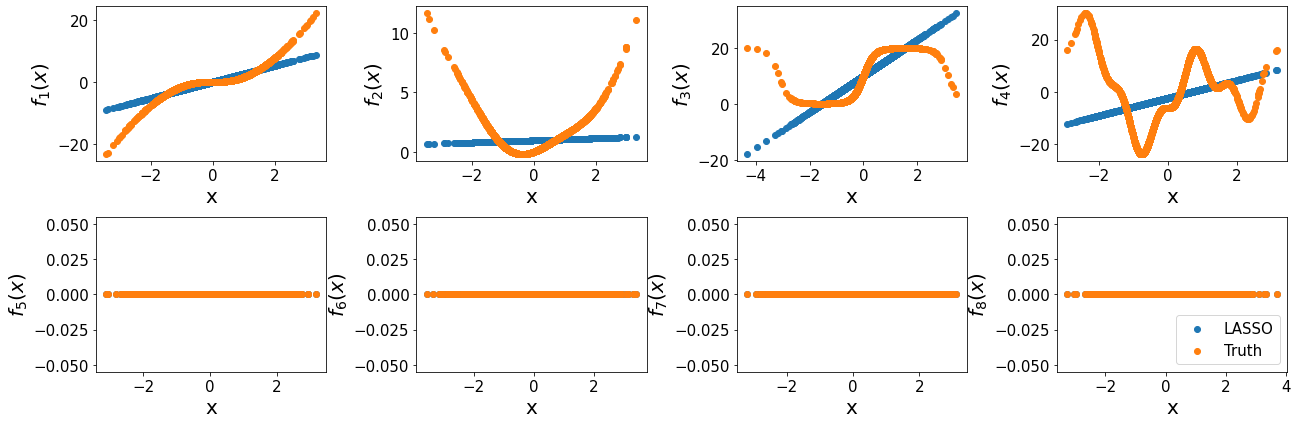

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

i = 0
for row in axes:
    for col in row:
        if i < len(features):
            f_i = features[i](X_train[:, i])
        else: 
            f_i = np.zeros_like(X_train[:, i])
        f_i_hat = X_train[:, i]*clf.coef_[i]
        c_i=np.mean(f_i_hat-f_i) 
        col.scatter(X_train[:, i], f_i_hat-c_i, label='LASSO')
        col.scatter(X_train[:, i], f_i, label='Truth')
        if i == 7:
            col.legend(fontsize='15', loc=4)
        col.xaxis.set_tick_params(labelsize=15)
        col.yaxis.set_tick_params(labelsize=15)
        col.set_xlabel('x', fontsize='20')
        col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
        i += 1

fig.tight_layout()
fig.savefig(path+'plot_synRG_lasso.pdf', bbox_inches='tight')
plt.show()        

### With selected features

In [16]:
## best features used by freyberger et al:
features_freyberger = ['d_shrout', 'd_so', 'investment', 'lme', 'lturnover', 
                       'pm_adj', 'cum_return_1_0', 'cum_return_12_2', 'cum_return_12_7', 
                       'rel_to_high_price', 'roc','suv', 'total_vol','TARGET']
features_rf = ['d_shrout', 'roe', 'oa', 'free_cf', 'nop', 'dpi2a', 'rna', 'ato', 'd_dgm_dsales', 'roc', 'ipm', 'spread_mean', 'dto', 'suv', 'TARGET']
features_ae = ['e2p', 'beme', 'cum_return_12_2', 'cum_return_12_7', 'mm_sin', 'mm_cos', 'yy', 'dpi2a', 'ret', 'total_vol', 'noa', 'std_volume', 'dto', 'cto', 'TARGET']

In [14]:
print(len(features_rf), " - ", len(features_ae), " - ", len(features_freyberger))

15  -  15  -  14


In [10]:
rmse, mae, mse, outputs, targets, f_te = predict_and_evaluate_model(model, testloader)
print(f'Test performance: RMSE: {rmse}, MAE: {mae}, MSE: {mse}')

NameError: name 'predict_and_evaluate_model' is not defined

### Try reload and predict again

In [35]:
saved_model = torch.load('./models/model_60.pth')

In [39]:
rmse, mae, mse, outputs, targets, f_te = predict_and_evaluate_model(saved_model, testloader, wandb_log=False)
print(f'Test performance: RMSE: {rmse}, MAE: {mae}, MSE: {mse}')

Test performance: RMSE: 0.2081463783979416, MAE: 0.130947083234787, MSE: 0.04330037906765938


In [27]:
### Helper method to visualize prediction vs true values
import random
#plt.style.use("seaborn")

permnos_total = X_train.index.droplevel(['permno'])

def visualize_sample_prediction(y_test, y_pred):
    # Picks a random stock, to visualize its real returns 
    # against the predicted returns
    sample_permno = random.choice(permnos_total)
    ## delete:
    #sample_permno = 51625
    #sample_test_y = y_test.xs(sample_permno, level='permno')
    idx = X_valid.index.droplevel(['permno'])
    #sample_test_idx = sample_test_y.index.get_level_values('date')
    #print(len(idx))
    #y_pred = pd.Series(y_pred, index=y_test.index)
    #sample_pred = y_pred.xs(sample_permno, level='permno')
    print(len(y_test))
    fig,ax=plt.subplots(figsize=(18,6))

    ax.scatter(x=idx, y= y_valid, color='r')
    ax.scatter(x=idx, y= y_pred, color='b')
    plt.title(f'Stock nr {sample_permno} predicted returns (blue) vs actual returns (red)')
    plt.show()

In [ ]:
visualize_sample_prediction()

#### Training with samplenet as subnets #### 

In [ ]:
### TRAINING WITH SAMPLENET AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 2, 5e-3, int(100), True, X_train.shape[1] # lbd = lambda for regularization
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid, batch_size=256, MSE=MSE)

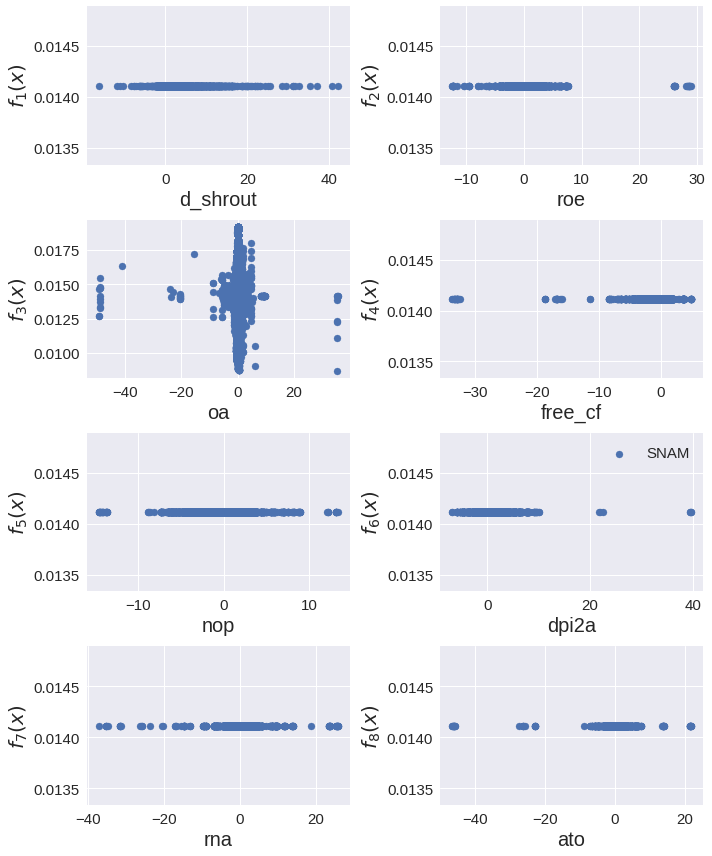

In [150]:
plot_shape_functions(f_out_tr, save=True)

#### Training with Pyramidnet as Subnetworks

In [17]:
### TRAINING WITH Pyramidnet AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 2, 5e-3, int(100), True, X_train.shape[1] # what is lbd??
trainloader, testloader, output_size = data_totensor(X_train, X_valid, y_train, y_valid, batch_size=256, MSE=MSE)

start = time.time()
[test_loss, f_out_tr_2, f_out_te, model, train_loss_history, test_loss_history] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE, pyramid=True)
time_spent =  time.time()-start 

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], features, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)

NameError: name 'X_train' is not defined

## California housing dataset

In [13]:
from sklearn.model_selection import train_test_split
ch_data = sklearn.datasets.fetch_california_housing()

X = ch_data.data
y = ch_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
print(X_train.shape, X_test.shape)

(16512, 8) (4128, 8)


In [15]:
#### utilsss!!!
def data_totensor(X_train, X_test, y_train, y_test, batch_size = 256, batch_size_test=1000,save=False, MSE=True):
    
    #%% separate data into three parts: train, validation(?) and test. 
    if MSE: 
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1)
        D_out = 1
    else:
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).long()
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).long()
        D_out = 2

    Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=False)
    Test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size_test, shuffle=False)
    
    if save== True:
        f = open(path+"data/p2_data.pkl","wb")
        pickle.dump([trainloader, testloader, D_out], f)
        f.close()
    
    return trainloader, testloader, D_out 

In [46]:
### TRAINING WITH SampleNet AS SUBNETWORKS ###

lbd, lr, max_epoch, MSE, n_features = 1, 10e-5, int(100), True, X_train.shape[1] # lambda
trainloader, testloader, output_size = data_totensor(X_train, X_test, y_train, y_test, batch_size=256, MSE=MSE)

start = time.time()
[test_loss, f_out_tr, f_out_te, model, train_loss_history, test_loss_history] = simuADAM(trainloader, testloader, lbd, lr, max_epoch, n_features=n_features, output_size=1, opti_name='Adam', 
                    MSE=MSE)
time_spent =  time.time()-start 

#iden_error = iden_error_spam(X_train, f_out_tr[:,:,0], features, plot=True)
print('f_tr_out: ', np.mean(f_out_tr, axis=0))
print('time spent: ', time_spent, ' sec')
print('test loss: ', test_loss)

Loss test:,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁
max_epochs,▁
n_features,▁
Loss test:,0.53314
Train Loss,0.54203
learning_rate,0.0001
max_epochs,50
n_features,8
optimizer,Adam


training with lbd:  1
Training on: cuda:0
################################## START OF TRAINING ##################################
##### Training Epoch Nr: 0 started ####
Early stopping counter:  0


65it [00:00, 87.50it/s]
65it [00:00, 88.23it/s]
65it [00:00, 87.35it/s]
65it [00:00, 67.79it/s]
65it [00:00, 87.81it/s]


##### Training Epoch Nr: 5 started ####
Early stopping counter:  0


65it [00:00, 87.89it/s]
65it [00:00, 88.13it/s]
65it [00:00, 87.77it/s]
65it [00:00, 87.99it/s]
65it [00:00, 88.32it/s]


test loss : 0.8756058931350708
epoch:  10 Loss train:  0.9238719188250029 Loss test:  0.8756058931350708
##### Training Epoch Nr: 10 started ####
Early stopping counter:  0


65it [00:00, 87.84it/s]
65it [00:00, 87.70it/s]
65it [00:00, 87.78it/s]
65it [00:00, 88.30it/s]
65it [00:00, 88.38it/s]


##### Training Epoch Nr: 15 started ####
Early stopping counter:  0


65it [00:00, 87.58it/s]
65it [00:00, 88.18it/s]
65it [00:00, 87.75it/s]
65it [00:00, 88.26it/s]
65it [00:00, 87.54it/s]


test loss : 0.6306632041931153
epoch:  20 Loss train:  0.6346596612380101 Loss test:  0.6306632041931153
##### Training Epoch Nr: 20 started ####
Early stopping counter:  0


65it [00:00, 87.50it/s]
65it [00:00, 87.95it/s]
65it [00:00, 88.04it/s]
65it [00:00, 88.23it/s]
65it [00:00, 88.19it/s]


##### Training Epoch Nr: 25 started ####
Early stopping counter:  0


65it [00:00, 70.62it/s]
65it [00:00, 88.55it/s]
65it [00:00, 87.80it/s]
65it [00:00, 87.86it/s]
65it [00:00, 88.38it/s]


test loss : 0.5862131774425506
epoch:  30 Loss train:  0.5808775567091429 Loss test:  0.5862131774425506
##### Training Epoch Nr: 30 started ####
Early stopping counter:  0


65it [00:00, 87.34it/s]
65it [00:00, 87.95it/s]
65it [00:00, 87.85it/s]
65it [00:00, 87.94it/s]
65it [00:00, 88.30it/s]


##### Training Epoch Nr: 35 started ####
Early stopping counter:  0


65it [00:00, 87.71it/s]
65it [00:00, 87.99it/s]
65it [00:00, 88.08it/s]
65it [00:00, 87.31it/s]
65it [00:00, 85.87it/s]


test loss : 0.5434629917144775
epoch:  40 Loss train:  0.5521023974968837 Loss test:  0.5434629917144775
##### Training Epoch Nr: 40 started ####
Early stopping counter:  0


65it [00:00, 85.05it/s]
65it [00:00, 85.61it/s]
65it [00:00, 85.84it/s]
65it [00:00, 68.89it/s]
65it [00:00, 86.43it/s]


##### Training Epoch Nr: 45 started ####
Early stopping counter:  0


65it [00:00, 86.24it/s]
65it [00:00, 86.22it/s]
65it [00:00, 86.21it/s]
65it [00:00, 86.45it/s]
65it [00:00, 85.88it/s]


test loss : 0.5331398665904998
epoch:  50 Loss train:  0.5420332390528458 Loss test:  0.5331398665904998
##### Training Epoch Nr: 50 started ####
Early stopping counter:  0


65it [00:00, 85.66it/s]
65it [00:00, 86.32it/s]
65it [00:00, 86.45it/s]
65it [00:00, 85.91it/s]
65it [00:00, 86.20it/s]


##### Training Epoch Nr: 55 started ####
Early stopping counter:  0


65it [00:00, 85.33it/s]
65it [00:00, 86.01it/s]
65it [00:00, 85.89it/s]
65it [00:00, 85.83it/s]
65it [00:00, 69.29it/s]


test loss : 0.537965452671051
epoch:  60 Loss train:  0.5497660875320435 Loss test:  0.537965452671051
##### Training Epoch Nr: 60 started ####
Early stopping counter:  0


65it [00:00, 86.00it/s]
65it [00:00, 85.81it/s]
65it [00:00, 85.99it/s]
65it [00:00, 86.24it/s]
65it [00:00, 86.08it/s]


##### Training Epoch Nr: 65 started ####
Early stopping counter:  0


65it [00:00, 85.65it/s]
65it [00:00, 86.12it/s]
65it [00:00, 85.79it/s]
65it [00:00, 85.76it/s]
65it [00:00, 85.99it/s]


test loss : 0.5367823481559754
epoch:  70 Loss train:  0.5513448719794933 Loss test:  0.5367823481559754
##### Training Epoch Nr: 70 started ####
Early stopping counter:  0


65it [00:00, 86.00it/s]
65it [00:00, 86.02it/s]
65it [00:00, 85.84it/s]
65it [00:00, 86.26it/s]
65it [00:00, 85.77it/s]


##### Training Epoch Nr: 75 started ####
Early stopping counter:  0


65it [00:00, 85.88it/s]
65it [00:00, 86.10it/s]
65it [00:00, 86.33it/s]
65it [00:00, 86.19it/s]
65it [00:00, 86.80it/s]


test loss : 0.6310888409614563
epoch:  80 Loss train:  0.6264799938752101 Loss test:  0.6310888409614563
##### Training Epoch Nr: 80 started ####
Early stopping counter:  0


65it [00:00, 85.55it/s]
65it [00:00, 85.91it/s]
65it [00:00, 85.76it/s]
65it [00:00, 86.24it/s]
65it [00:00, 85.96it/s]


##### Training Epoch Nr: 85 started ####
Early stopping counter:  0


65it [00:00, 86.25it/s]
65it [00:00, 84.85it/s]
65it [00:00, 86.10it/s]
65it [00:00, 86.38it/s]
65it [00:00, 86.13it/s]


test loss : 0.9169337034225464
epoch:  90 Loss train:  0.7557392285420345 Loss test:  0.9169337034225464
##### Training Epoch Nr: 90 started ####
Early stopping counter:  0


65it [00:00, 85.69it/s]
65it [00:00, 85.61it/s]
65it [00:00, 85.89it/s]
65it [00:00, 86.05it/s]
65it [00:00, 85.69it/s]


##### Training Epoch Nr: 95 started ####
Early stopping counter:  0


65it [00:00, 85.59it/s]
65it [00:00, 86.27it/s]
65it [00:00, 66.83it/s]
65it [00:00, 86.21it/s]
65it [00:00, 85.91it/s]

test loss : 0.8956698536872864
epoch:  100 Loss train:  0.7484330525765053 Loss test:  0.8956698536872864
f_tr_out:  [[ 1.2371765e+00]
 [ 4.9560669e-01]
 [-9.3930257e-06]
 [-1.4443558e-06]
 [-8.3350455e-03]
 [-1.4335108e-06]
 [-1.3821381e+00]
 [ 1.7210741e+00]]
time spent:  86.20256662368774  sec
test loss:  0.8956698536872864



/scratch/slurm_tmpdir/job_20991135/ipykernel_2718888/284834048.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return [test_loss, np.vstack(np.array(f_out_tr)), np.vstack(np.array(f_out_te)), model, epoch_train_loss_history, epoch_test_loss_history]


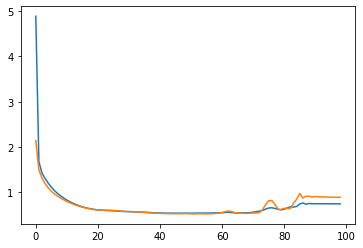

In [47]:
plt.plot(train_loss_history[1:])
plt.plot(test_loss_history[1:])
#plt.savefig()

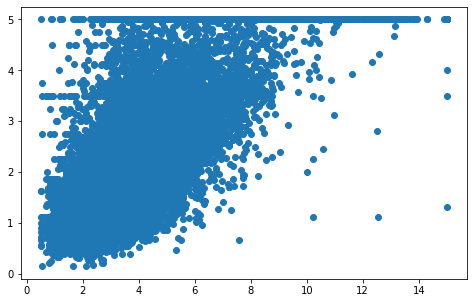

In [68]:
y_smooth = pd.Series(y_train).rolling(18).mean()
plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], y_train)

In [69]:
f_out_tr.shape

(16512, 8, 1)

In [19]:
#### replaced by utils.py !! ####
def load_model(model_dir, run_id):
    model = torch.load(f'{model_dir}model_{run_id}.pth')
    return model

In [20]:
# do one forward pass
model_dir = "./models/SNAM/"
run_id = '84_ch'
pretrained_model = load_model(model_dir, run_id)

AttributeError: Can't get attribute 'NAM' on <module '__main__'>

In [ ]:
# do one forward pass
for idx1, (inputs, targets) in tqdm(enumerate(trainloader)): 
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs, f_out_tr_temp = model(inputs)[0],model(inputs)[1].detach().cpu().numpy()

In [27]:
feature_names = ch_data.feature_names
res_path = './results'

# Plot shape functions
def plot_CH_shape_functions(X, y, f_tr, feature_names, res_path=res_path):
    features = y
    for i in range(f_tr.shape[1]):
        if i < y.shape[0]:
            f_i = y
        else: f_i = np.zeros_like(X[:, i])
        c_i=np.mean(f_tr[:,[i]]-f_i)

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))

    i = 0
    for row in axes:
        for col in row:
            if i < y.shape[0]:
                f_i = y
            else: 
                f_i = np.zeros_like(X[:, i])
            c_i=np.mean(f_tr[:,[i]]-f_i) 
            col.scatter(X[:, i], f_tr[:, [i]]-c_i, label='SNAM')
            #col.scatter(X_train, features[i](X_train))
            if i == 8:
                col.legend(fontsize='15')
            col.xaxis.set_tick_params(labelsize=15)
            col.yaxis.set_tick_params(labelsize=15)
            col.set_xlabel(f'{feature_names[i]}', fontsize='20')
            col.set_ylabel(r'$f_{}(x)$'.format(i+1), fontsize='20')
            i += 1

    fig.tight_layout()
    fig.savefig(res_path+'plot_CH_snam.png', bbox_inches='tight')
    plt.show()        

In [30]:
print(X_train.shape, " - ", f_out_tr.shape)

(16512, 8)  -  (16512, 8, 1)


In [29]:
print(X_test.shape, " - ", f_out_te.shape)

(4128, 8)  -  (1024, 1)


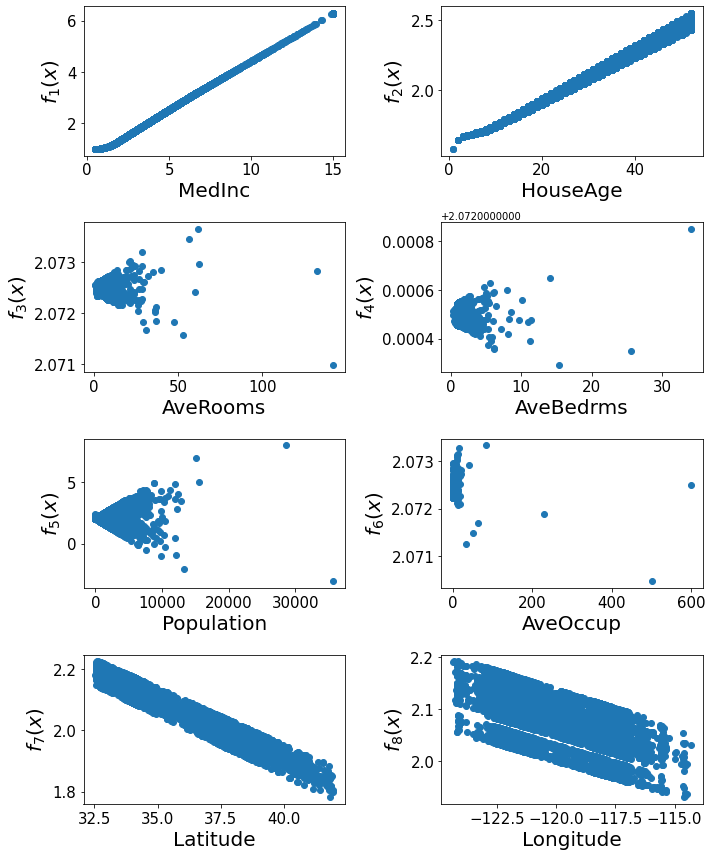

In [48]:
plot_CH_shape_functions(X_train, y_train, f_out_tr, feature_names)

Notice:
Cannot reproduce plots from paper on California Housing dataset.
-> Something might be off with the plot function...